In [1]:
DATA_PATH = "../data/processed/02_cleaned_data.pkl"

MLFLOW_TRACKING_URI = "../models/mlruns"
MLFLOW_EXPERIMENT_NAME = "car_price_prediction"

LOG_PATH = "../models/temp/"
LOG_DATA_PKL = "data.pkl"
LOG_MODEL_PKL = "model.pkl"
LOG_METRICS_PKL = "metrics.pkl"

In [183]:
# Load packages
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path
import os
import pickle

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import mlflow
from mlflow.tracking import MlflowClient


pd.options.display.max_columns = 100
%matplotlib inline

___
## Functions

In [4]:
def calculate_quality(ground_truth, predictions, metric_function, model_name):
    """
    Calculate the quality of the model according to different metric scores
    Input:
        ground_truth: from real observed data
        predictions: the predicted values from the model
        metric_function: the metric score funcrion used to measure performance
    Output:
        A dict of all scores for the given inputs
    """
    quality_score = {}
    quality_score[model_name] = round(metric_function(ground_truth, predictions), 3)
    quality_score = pd.Series(quality_score.values(), index=quality_score.keys())
    
    return quality_score

___
## Read data:

In [5]:
df = pd.read_pickle(DATA_PATH)
df.sample(5)

,year,engine_hp,engine_cylinders,transmission_type,msrp,speed,acura,alfa_romeo,aston_martin,audi,bentley,bmw,bugatti,buick,cadillac,chevrolet,chrysler,dodge,ferrari,fiat,ford,genesis,gmc,honda,hummer,hyundai,infiniti,kia,lamborghini,land_rover,lexus,lincoln,lotus,maserati,maybach,mazda,mclaren,mercedes-benz,mitsubishi,nissan,oldsmobile,plymouth,pontiac,porsche,rolls-royce,saab,scion,spyker,subaru,suzuki,tesla,toyota,volkswagen,volvo
9581,27,355.0,8.0,2,10.814585,19.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8132,13,175.0,6.0,2,9.972594,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7633,28,280.0,6.0,2,10.637561,23.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2689,26,355.0,4.0,3,10.789340,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8774,14,120.0,4.0,2,9.694062,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


___
## Splitting data into train and test:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('msrp', axis=1),
                                                    df[['msrp']],
                                                    test_size=0.2,
                                                    random_state=42)

In [8]:
# quick check of splitted data:
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
X_train.sample(5)

X_train shape (6873, 53)
X_test shape (1719, 53)


,year,engine_hp,engine_cylinders,transmission_type,speed,acura,alfa_romeo,aston_martin,audi,bentley,bmw,bugatti,buick,cadillac,chevrolet,chrysler,dodge,ferrari,fiat,ford,genesis,gmc,honda,hummer,hyundai,infiniti,kia,lamborghini,land_rover,lexus,lincoln,lotus,maserati,maybach,mazda,mclaren,mercedes-benz,mitsubishi,nissan,oldsmobile,plymouth,pontiac,porsche,rolls-royce,saab,scion,spyker,subaru,suzuki,tesla,toyota,volkswagen,volvo
9072,26,276.0,6.0,2,21.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7193,19,150.0,5.0,1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5906,24,98.0,4.0,2,42.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,15,200.0,6.0,1,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7857,26,330.0,6.0,2,20.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


___ 
## Trying the base model:

### Intialize MLflow

In [9]:
# Intialize client and experiment
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient()

In [10]:
# Check if experiment already exists; if not create one
try:
    mlflow.create_experiment(MLFLOW_EXPERIMENT_NAME)
except:
    print(f'Experiment "{MLFLOW_EXPERIMENT_NAME}" exists at "{mlflow.get_tracking_uri()}"')

Experiment "car_price_prediction" exists at "../models/mlruns"


In [11]:
exp = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
print(exp)

<Experiment: artifact_location='../models/mlruns/1', experiment_id='1', lifecycle_stage='active', name='car_price_prediction', tags={}>


___
## Training different models
### 1. Ridgeregression

In [21]:
ridge = make_pipeline(MinMaxScaler(), Ridge(alpha=0.3))

ridge.fit(X_train.values, y_train.values)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('ridge', Ridge(alpha=0.3))])

**Evaluate on training data**

In [22]:
# Evaluate on training set:
predictions = pd.DataFrame(ridge.predict(X_train.values),
                          columns=y_train.columns)

train_scores = {score.__name__:calculate_quality(y_train, predictions, score, "RidgeRegression")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

train_scores = pd.concat(train_scores, axis=1)
train_scores

,r2_score,mean_squared_error,mean_absolute_error
RidgeRegression,0.828,0.023,0.12


In [20]:
mean_train_score = train_scores.mean()
mean_train_score

r2_score               0.828
mean_squared_error     0.023
mean_absolute_error    0.120
dtype: float64

**Evaluate on testing data**

In [23]:
# Evaluate on testing set:
predictions = pd.DataFrame(ridge.predict(X_test.values),
                           columns=y_train.columns)

test_scores = {score.__name__:calculate_quality(y_test, predictions, score, "RidgeRegression")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

test_scores = pd.concat(test_scores, axis=1)
test_scores

,r2_score,mean_squared_error,mean_absolute_error
RidgeRegression,0.827,0.023,0.121


In [24]:
mean_test_score = test_scores.mean()
mean_test_score

r2_score               0.827
mean_squared_error     0.023
mean_absolute_error    0.121
dtype: float64

**Log Run**

In [25]:
# Data details
data_details = {"data_path": DATA_PATH,
                "training_indices": X_train.index.tolist(),
                "test_indices": X_test.index.tolist(),
                "feature_names": X_train.columns.tolist(),
                "target_names": y_train.columns.tolist()}

with open(os.path.join(LOG_PATH, LOG_DATA_PKL), "wb") as output_file:
    pickle.dump(data_details, output_file)

In [26]:
# Model details
model = {"model_description": "Ridge-Regression",
         "model_details": str(ridge),
         "model_object": ridge}

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [27]:
# Performance details
regression_metrics = {"train_scores": train_scores,
                      "test_scores": test_scores}

with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(regression_metrics, output_file)

**Logging**

In [28]:
# Start a new run and track
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # log pickle
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics
    for metric, score in mean_test_score.items():
        mlflow.log_metric(metric, score)

___
### 2. Lasso Regression

In [39]:
lasso = make_pipeline(MinMaxScaler(), Lasso(alpha=0.1))

lasso.fit(X_train.values, y_train.values)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('lasso', Lasso(alpha=0.1))])

**Evaluate on training data**

In [40]:
# Evaluate on training set:
predictions = pd.DataFrame(lasso.predict(X_train.values),
                          columns=y_train.columns)

train_scores = {score.__name__:calculate_quality(y_train, predictions, score, "LassoRegression")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

train_scores = pd.concat(train_scores, axis=1)
train_scores

,r2_score,mean_squared_error,mean_absolute_error
LassoRegression,0.0,0.134,0.298


In [41]:
mean_train_score = train_scores.mean()
mean_train_score

r2_score               0.000
mean_squared_error     0.134
mean_absolute_error    0.298
dtype: float64

**Evaluate on testing data**

In [42]:
# Evaluate on testing set:
predictions = pd.DataFrame(lasso.predict(X_test.values),
                           columns=y_train.columns)

test_scores = {score.__name__:calculate_quality(y_test, predictions, score, "LassoRegression")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

test_scores = pd.concat(test_scores, axis=1)
test_scores

,r2_score,mean_squared_error,mean_absolute_error
LassoRegression,-0.002,0.133,0.298


In [43]:
mean_test_score = test_scores.mean()
mean_test_score

r2_score              -0.002
mean_squared_error     0.133
mean_absolute_error    0.298
dtype: float64

**Log Run**

In [44]:
# Data details
data_details = {"data_path": DATA_PATH,
                "training_indices": X_train.index.tolist(),
                "test_indices": X_test.index.tolist(),
                "feature_names": X_train.columns.tolist(),
                "target_names": y_train.columns.tolist()}

with open(os.path.join(LOG_PATH, LOG_DATA_PKL), "wb") as output_file:
    pickle.dump(data_details, output_file)

In [46]:
# Model details
model = {"model_description": "Lasso-Regression",
         "model_details": str(lasso),
         "model_object": lasso}

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [47]:
# Performance details
regression_metrics = {"train_scores": train_scores,
                      "test_scores": test_scores}

with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(regression_metrics, output_file)

**Logging**

In [48]:
# Start a new run and track
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # log pickle
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics
    for metric, score in mean_test_score.items():
        mlflow.log_metric(metric, score)

___
### 3. SVR

In [58]:
svr = make_pipeline(MinMaxScaler(), SVR())

svr.fit(X_train.values, (y_train.values).reshape(-1,))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svr', SVR())])

**Evaluate on training data**

In [59]:
# Evaluate on training set:
predictions = pd.DataFrame(svr.predict(X_train.values),
                          columns=y_train.columns)

train_scores = {score.__name__:calculate_quality(y_train, predictions, score, "SVR")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

train_scores = pd.concat(train_scores, axis=1)
train_scores

,r2_score,mean_squared_error,mean_absolute_error
SVR,0.867,0.018,0.106


In [60]:
mean_train_score = train_scores.mean()
mean_train_score

r2_score               0.867
mean_squared_error     0.018
mean_absolute_error    0.106
dtype: float64

**Evaluate on testing data**

In [61]:
# Evaluate on testing set:
predictions = pd.DataFrame(svr.predict(X_test.values),
                           columns=y_train.columns)

test_scores = {score.__name__:calculate_quality(y_test, predictions, score, "SVR")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

test_scores = pd.concat(test_scores, axis=1)
test_scores

,r2_score,mean_squared_error,mean_absolute_error
SVR,0.862,0.018,0.109


In [62]:
mean_test_score = test_scores.mean()
mean_test_score

r2_score               0.862
mean_squared_error     0.018
mean_absolute_error    0.109
dtype: float64

**Log Run**

In [63]:
# Data details
data_details = {"data_path": DATA_PATH,
                "training_indices": X_train.index.tolist(),
                "test_indices": X_test.index.tolist(),
                "feature_names": X_train.columns.tolist(),
                "target_names": y_train.columns.tolist()}

with open(os.path.join(LOG_PATH, LOG_DATA_PKL), "wb") as output_file:
    pickle.dump(data_details, output_file)

In [64]:
# Model details
model = {"model_description": "Support Vector Regressor (SVR)",
         "model_details": str(svr),
         "model_object": svr}

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [65]:
# Performance details
regression_metrics = {"train_scores": train_scores,
                      "test_scores": test_scores}

with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(regression_metrics, output_file)

**Logging**

In [66]:
# Start a new run and track
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # log pickle
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics
    for metric, score in mean_test_score.items():
        mlflow.log_metric(metric, score)

___
### 4. Decission-Tree-Regressor

In [145]:
dt = make_pipeline(MinMaxScaler(),
                   DecisionTreeRegressor(max_depth=12))

dt.fit(X_train.values, y_train.values)
# Note: we tried different values for max_depth and values above 
# 10 tends to overfit

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor(max_depth=12))])

**Evaluate on training data**

In [146]:
# Evaluate on training set:
predictions = pd.DataFrame(dt.predict(X_train.values),
                          columns=y_train.columns)

train_scores = {score.__name__:calculate_quality(y_train, predictions, score, "DecisionTreeRegressor")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

train_scores = pd.concat(train_scores, axis=1)
train_scores

,r2_score,mean_squared_error,mean_absolute_error
DecisionTreeRegressor,0.908,0.012,0.084


In [147]:
mean_train_score = train_scores.mean()
mean_train_score

r2_score               0.908
mean_squared_error     0.012
mean_absolute_error    0.084
dtype: float64

**Evaluate on testing data**

In [148]:
# Evaluate on testing set:
predictions = pd.DataFrame(dt.predict(X_test.values),
                           columns=y_train.columns)

test_scores = {score.__name__:calculate_quality(y_test, predictions, score, "DecisionTreeRegressor")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

test_scores = pd.concat(test_scores, axis=1)
test_scores

,r2_score,mean_squared_error,mean_absolute_error
DecisionTreeRegressor,0.865,0.018,0.103


In [149]:
mean_test_score = test_scores.mean()
mean_test_score

r2_score               0.865
mean_squared_error     0.018
mean_absolute_error    0.103
dtype: float64

**Log Run**

In [150]:
# Data details
data_details = {"data_path": DATA_PATH,
                "training_indices": X_train.index.tolist(),
                "test_indices": X_test.index.tolist(),
                "feature_names": X_train.columns.tolist(),
                "target_names": y_train.columns.tolist()}

with open(os.path.join(LOG_PATH, LOG_DATA_PKL), "wb") as output_file:
    pickle.dump(data_details, output_file)

In [151]:
# Model details
model = {"model_description": "Decision Tree Regressor",
         "model_details": str(dt),
         "model_object": dt}

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [152]:
# Performance details
regression_metrics = {"train_scores": train_scores,
                      "test_scores": test_scores}

with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(regression_metrics, output_file)

**Logging**

In [153]:
# Start a new run and track
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # log pickle
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics
    for metric, score in mean_test_score.items():
        mlflow.log_metric(metric, score)

___
### 5. Random-Forest-Regressor

In [155]:
rf = make_pipeline(MinMaxScaler(),
                   RandomForestRegressor(max_depth=12))

rf.fit(X_train.values, (y_train.values).reshape(-1,))
# Note: we tried different values for max_depth and values above 
# 10 tends to overfit

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor', RandomForestRegressor(max_depth=12))])

**Evaluate on training data**

In [156]:
# Evaluate on training set:
predictions = pd.DataFrame(rf.predict(X_train.values),
                          columns=y_train.columns)

train_scores = {score.__name__:calculate_quality(y_train, predictions, score, "RandomForestRegressor")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

train_scores = pd.concat(train_scores, axis=1)
train_scores

,r2_score,mean_squared_error,mean_absolute_error
RandomForestRegressor,0.924,0.01,0.079


In [157]:
mean_train_score = train_scores.mean()
mean_train_score

r2_score               0.924
mean_squared_error     0.010
mean_absolute_error    0.079
dtype: float64

**Evaluate on testing data**

In [177]:
# Evaluate on testing set:
predictions = pd.DataFrame(rf.predict(X_test.values),
                           columns=y_train.columns)

test_scores = {score.__name__:calculate_quality(y_test, predictions, score, "RandomForestRegressor")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

test_scores = pd.concat(test_scores, axis=1)
test_scores

,r2_score,mean_squared_error,mean_absolute_error
RandomForestRegressor,0.895,0.014,0.094


In [159]:
mean_test_score = test_scores.mean()
mean_test_score

r2_score               0.895
mean_squared_error     0.014
mean_absolute_error    0.094
dtype: float64

**Log Run**

In [160]:
# Data details
data_details = {"data_path": DATA_PATH,
                "training_indices": X_train.index.tolist(),
                "test_indices": X_test.index.tolist(),
                "feature_names": X_train.columns.tolist(),
                "target_names": y_train.columns.tolist()}

with open(os.path.join(LOG_PATH, LOG_DATA_PKL), "wb") as output_file:
    pickle.dump(data_details, output_file)

In [161]:
# Model details
model = {"model_description": "Random Forest Regressor",
         "model_details": str(rf),
         "model_object": rf}

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [162]:
# Performance details
regression_metrics = {"train_scores": train_scores,
                      "test_scores": test_scores}

with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(regression_metrics, output_file)

**Logging**

In [163]:
# Start a new run and track
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # log pickle
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics
    for metric, score in mean_test_score.items():
        mlflow.log_metric(metric, score)

___
### 6. K-Nearest-Neighbor

In [233]:
metrics_val = []
for K in range(1,25):
    knn = make_pipeline(MinMaxScaler(),
                       KNeighborsRegressor(n_neighbors=K))

    knn.fit(X_train.values, y_train.values)
    
    # Evaluate on training set:
    predictions = pd.DataFrame(knn.predict(X_train.values),
                              columns=y_train.columns)
    train_scores = {score.__name__+"_train":calculate_quality(y_train, predictions, score, f"KNeighborsRegressor(k={K})")
                    for score in [r2_score, mean_squared_error, mean_absolute_error]}
    train_scores = pd.concat(train_scores, axis=1)
    
    
    # Evaluate on testing set:
    predictions = pd.DataFrame(knn.predict(X_test.values),
                              columns=y_train.columns)
    test_scores = {score.__name__+"_test":calculate_quality(y_test, predictions, score, f"KNeighborsRegressor(k={K})")
                    for score in [r2_score, mean_squared_error, mean_absolute_error]}
    test_scores = pd.concat(test_scores, axis=1)
    
    series = pd.merge(train_scores, test_scores, left_index=True, right_index=True)

    metrics_val.append(series)

metrics_val = pd.concat(metrics_val, axis=0)
metrics_val

,r2_score_train,mean_squared_error_train,mean_absolute_error_train,r2_score_test,mean_squared_error_test,mean_absolute_error_test
KNeighborsRegressor(k=1),0.920,0.011,0.062,0.853,0.020,0.112
KNeighborsRegressor(k=2),0.938,0.008,0.068,0.882,0.016,0.099
KNeighborsRegressor(k=3),0.935,0.009,0.071,0.887,0.015,0.097
KNeighborsRegressor(k=4),0.930,0.009,0.075,0.886,0.015,0.098
KNeighborsRegressor(k=5),0.924,0.010,0.078,0.883,0.016,0.098
KNeighborsRegressor(k=6),0.918,0.011,0.082,0.879,0.016,0.100
KNeighborsRegressor(k=7),0.912,0.012,0.085,0.876,0.016,0.101
KNeighborsRegressor(k=8),0.907,0.013,0.088,0.873,0.017,0.102
KNeighborsRegressor(k=9),0.902,0.013,0.090,0.869,0.017,0.104
KNeighborsRegressor(k=10),0.897,0.014,0.092,0.865,0.018,0.105


In [245]:
#Reset index so we can use index as the base for x-labels in plots
metrics_val.reset_index(inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

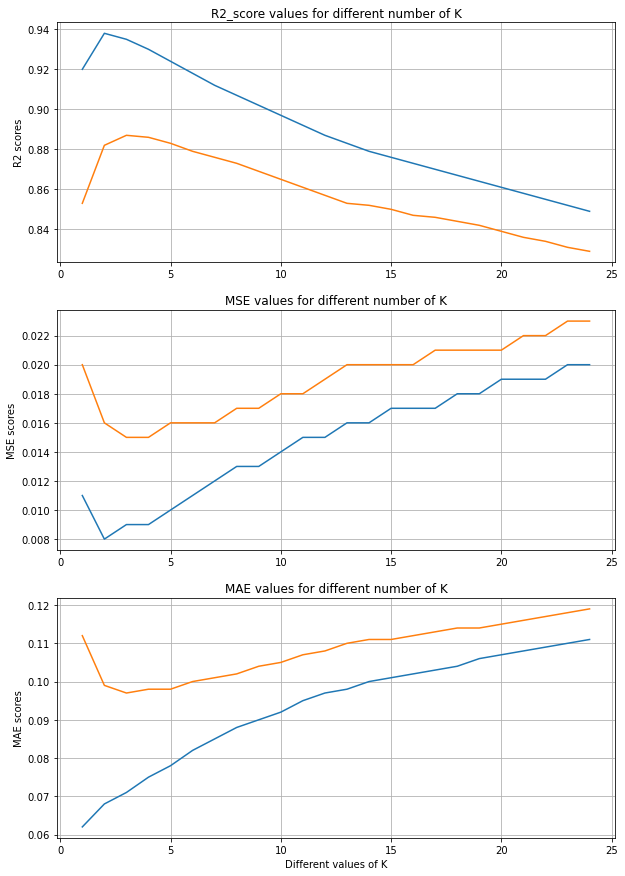

In [246]:
x_values = (metrics_val.index + 1).tolist()

plt.figure(figsize=(10, 15))
plt.subplot(3,1,1)
plt.plot(x_values, metrics_val.r2_score_train)
plt.plot(x_values, metrics_val.r2_score_test)
plt.title("R2_score values for different number of K")
plt.ylabel("R2 scores")
plt.grid()
plt.show

plt.subplot(3,1,2)
plt.plot(x_values, metrics_val.mean_squared_error_train)
plt.plot(x_values, metrics_val.mean_squared_error_test)
plt.title("MSE values for different number of K")
plt.ylabel("MSE scores")
plt.grid()
plt.show

plt.subplot(3,1,3)
plt.plot(x_values, metrics_val.mean_absolute_error_train)
plt.plot(x_values, metrics_val.mean_absolute_error_test)
plt.title("MAE values for different number of K")
plt.xlabel("Different values of K")
plt.ylabel("MAE scores")
plt.grid()
plt.show

**From the above calculations we can conclude that the best value for K is K=20**

In [237]:
knn = make_pipeline(MinMaxScaler(),
                   KNeighborsRegressor(n_neighbors=20))

knn.fit(X_train.values, y_train.values)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=20))])

**Evaluate on training data**

In [238]:
# Evaluate on training set:
predictions = pd.DataFrame(knn.predict(X_train.values),
                          columns=y_train.columns)

train_scores = {score.__name__:calculate_quality(y_train, predictions, score, "KNeighborsRegressor")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

train_scores = pd.concat(train_scores, axis=1)
train_scores

,r2_score,mean_squared_error,mean_absolute_error
KNeighborsRegressor,0.861,0.019,0.107


In [239]:
mean_train_score = train_scores.mean()
mean_train_score

r2_score               0.861
mean_squared_error     0.019
mean_absolute_error    0.107
dtype: float64

**Evaluate on testing data**

In [240]:
# Evaluate on testing set:
predictions = pd.DataFrame(knn.predict(X_test.values),
                           columns=y_train.columns)

test_scores = {score.__name__:calculate_quality(y_test, predictions, score, "KNeighborsRegressor")
                for score in [r2_score, mean_squared_error, mean_absolute_error]}

test_scores = pd.concat(test_scores, axis=1)
test_scores

,r2_score,mean_squared_error,mean_absolute_error
KNeighborsRegressor,0.839,0.021,0.115


In [241]:
mean_test_score = test_scores.mean()
mean_test_score

r2_score               0.839
mean_squared_error     0.021
mean_absolute_error    0.115
dtype: float64

**Log Run**

In [220]:
# Data details
data_details = {"data_path": DATA_PATH,
                "training_indices": X_train.index.tolist(),
                "test_indices": X_test.index.tolist(),
                "feature_names": X_train.columns.tolist(),
                "target_names": y_train.columns.tolist()}

with open(os.path.join(LOG_PATH, LOG_DATA_PKL), "wb") as output_file:
    pickle.dump(data_details, output_file)

In [242]:
# Model details
model = {"model_description": "K-Nearest-Neighbor Regressor",
         "model_details": str(knn),
         "model_object": knn}

with open(os.path.join(LOG_PATH, LOG_MODEL_PKL), "wb") as output_file:
    pickle.dump(model, output_file)

In [243]:
# Performance details
regression_metrics = {"train_scores": train_scores,
                      "test_scores": test_scores}

with open(os.path.join(LOG_PATH, LOG_METRICS_PKL), "wb") as output_file:
    pickle.dump(regression_metrics, output_file)

**Logging**

In [244]:
# Start a new run and track
with mlflow.start_run(experiment_id=exp.experiment_id, run_name=model["model_description"]):
    # log pickle
    mlflow.log_artifacts(LOG_PATH)
    
    # Track metrics
    for metric, score in mean_test_score.items():
        mlflow.log_metric(metric, score)